In [1]:
import os
import pandas as pd
from scipy import stats
from datetime import datetime, timedelta
import numpy as np
import traceback
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

Load LifeLines and REDCap variables

In [2]:
#Lifelines
path_high=os.getcwd()+"/Lifelines_BMI/high_BMI_lifelines_final.csv"
path_low=os.getcwd()+"/Lifelines_BMI/low_BMI_lifelines_final.csv"

#Redcap
path_redcap=os.getcwd()+"/redcap_levels/BMI_6-6-2023.csv"

In [1]:
high_BMI=pd.read_csv(path_high)
high_BMI

In [2]:
low_BMI=pd.read_csv(path_low)
low_BMI

In [5]:
#Change column 'age' to 'age_at_scan' to fit the previous version naming convention
high_BMI=high_BMI.rename(columns={"age":"age_at_scan"})
low_BMI=low_BMI.rename(columns={"age":"age_at_scan"})

In [6]:
BMI_lifelines=pd.concat([high_BMI,low_BMI])

Get RedCap export with detailed information for many variables

In [7]:
BMI_red=pd.read_csv(path_redcap) #Some cases like 386347 manually deleted since AI detected at least 10 nodules in them
# We also manually deleted participants with at least 10 nodules during initial reading [130781,334327]
BMI_redcap=BMI_red.copy() #Copy to create a graph below with BMI distribution of ImaLife

#Remove rows that participant_weight or participant_length is missing
BMI_redcap=BMI_redcap[BMI_redcap['participant_weight'].notna()]
BMI_redcap=BMI_redcap[BMI_redcap['participant_length'].notna()]

#Only keep rows with nodule_id_n10 not nan
BMI_redcap=BMI_redcap[~BMI_redcap['nodule_id_n10'].notna()]

#This will used again at the end of the script

In [8]:
#Select only the rows with the participants in the LifeLines cohort
BMI_red=BMI_red[BMI_red['participant_id'].isin(list(high_BMI['patientID'].values)+ list(low_BMI['patientID'].values))]

Use gender from RedCap export to avoid errors - LifeLines have a few missing variables

In [9]:
BMI_gender=BMI_red.copy() 
assert np.sum(BMI_gender['participant_gender___1']==1)+np.sum(BMI_gender['participant_gender___2']==1)==len(BMI_gender) #1 male, 2 female

In [3]:
BMI_gender['participant_gender___1']=BMI_gender['participant_gender___1'].map({1:'Male', 0:'Female'})
BMI_gender.rename(columns={'participant_gender___1': 'gender'}, inplace=True)
BMI_gender

In [11]:
BMI_gender_high=BMI_gender[BMI_gender['participant_id'].isin(list(high_BMI['patientID'].values))]
BMI_gender_low=BMI_gender[BMI_gender['participant_id'].isin(list(low_BMI['patientID'].values))]

Calculate age for LifeLines and REDCap and compare them

In [12]:
#Function to calculate age of participant from age in which he/she was born
def calculate_age(scan_date, birth_date):
    try:
        birth_date=datetime(int(birth_date[:4]),int(birth_date[5:7]),int(birth_date[8:10]),0,0)
        scan_date=datetime(int(scan_date[:4]),int(scan_date[5:7]),int(scan_date[8:10]),0,0)
        return int(scan_date.year - birth_date.year - ((scan_date.month, scan_date.day) < (birth_date.month, birth_date.day)))
    except:
        return np.nan

In [13]:
BMI_red['age_at_scan']=BMI_red.apply(lambda row: calculate_age(row['eval_date_th'],row['date_of_birth']), axis=1)
#was row['scan_date'] but changed due to discrepancies with Lifeline variables (which are correct)

In [14]:
BMI_red_high=BMI_red[BMI_red['participant_id'].isin(high_BMI['patientID'])]
BMI_red_low=BMI_red[BMI_red['participant_id'].isin(low_BMI['patientID'])]

In [4]:
#High BMI
total_null=0
for index,age in enumerate(high_BMI['age_at_scan'].values):
    if age==BMI_red_high['age_at_scan'].iloc[index]:
        pass
    else:
        if age<200: #Ensure no nan values are printed - ['scan_date'] changed to ['eval_date_th']
            print('From RedCap scan date is',BMI_red_high['eval_date_th'].iloc[index], 'and date of birth is',BMI_red_high['date_of_birth'].iloc[index])
            print("RedCap age is:",calculate_age(BMI_red_high['eval_date_th'].iloc[index],BMI_red_high['date_of_birth'].iloc[index]))
            print('From LifeLines age at scan is',age)
            print('Participant is:',high_BMI['patientID'].iloc[index])

            # Replace RedCap age with Lifelines age if RedCap age is nan
            if np.isnan(calculate_age(BMI_red_high['eval_date_th'].iloc[index],BMI_red_high['date_of_birth'].iloc[index])):
                BMI_red_high['age_at_scan'].iloc[index]=age
                print('Changed RedCap nan age to:',BMI_red_high['age_at_scan'].iloc[index])
                
                # Define the condition for matching participant_id
                condition = BMI_red['participant_id'] == BMI_red_high['participant_id'].iloc[index]
                # Update the 'age_at_scan' column based on the condition
                BMI_red.loc[condition, 'age_at_scan'] = age

                # print(BMI_red[BMI_red['participant_id']==BMI_red_high['participant_id'].iloc[index]]['age_at_scan'])

                print('\n')

            #Replace RedCap age with Lifelines age if RedCap age is 1 year older than Lifelines age
            elif calculate_age(BMI_red_high['eval_date_th'].iloc[index],BMI_red_high['date_of_birth'].iloc[index])==age+1:
                BMI_red_high['age_at_scan'].iloc[index]=age
                print('Changed RedCap age to:',BMI_red_high['age_at_scan'].iloc[index])

                # Define the condition for matching participant_id
                condition = BMI_red['participant_id'] == BMI_red_high['participant_id'].iloc[index]
                # Update the 'age_at_scan' column based on the condition
                BMI_red.loc[condition, 'age_at_scan'] = age

                # print(BMI_red[BMI_red['participant_id']==BMI_red_high['participant_id'].iloc[index]]['age_at_scan'])

                print('\n')

        else:
            total_null+=1
        #     # print('From RedCap scan date is',BMI_red_high['scan_date'].iloc[index], 'and date of birth is',BMI_red_high['date_of_birth'].iloc[index])
        #     # print('From LifeLines age at scan is',age)
        #     print('Nan values in LifeLines data for participant',high_BMI['patientID'].iloc[index])
        #     print('\n')

print('Total null values in LifeLines data:',total_null)
assert high_BMI.isnull()['age_at_scan'].sum()==total_null

In [5]:
#Low BMI
total_null=0
for index,age in enumerate(low_BMI['age_at_scan'].values):
    
    if age==BMI_red_low['age_at_scan'].iloc[index]:
        pass
    else:
        if age<200: #Ensure no nan values are printed
            print('From RedCap scan date is',BMI_red_low['eval_date_th'].iloc[index], 'and date of birth is',BMI_red_low['date_of_birth'].iloc[index])
            print("RedCap age is:",calculate_age(BMI_red_low['eval_date_th'].iloc[index],BMI_red_low['date_of_birth'].iloc[index]))
            print('From LifeLines age at scan is',age)
            print('Participant is:',low_BMI['patientID'].iloc[index])

            # Replace RedCap age with Lifelines age if RedCap age is nan - Just needed for assertion error
            if np.isnan(calculate_age(BMI_red_low['eval_date_th'].iloc[index],BMI_red_low['date_of_birth'].iloc[index])):
                BMI_red_low['age_at_scan'].iloc[index]=age
                print('Changed RedCap nan age to:',BMI_red_low['age_at_scan'].iloc[index])

                # Define the condition for matching participant_id
                condition = BMI_red['participant_id'] == BMI_red_low['participant_id'].iloc[index]
                # Update the 'age_at_scan' column based on the condition
                BMI_red.loc[condition, 'age_at_scan'] = age

                # print(BMI_red[BMI_red['participant_id']==BMI_red_low['participant_id'].iloc[index]]['age_at_scan'])

                print('\n')

            #Replace RedCap age with Lifelines age if RedCap age is 1 year older than Lifelines age
            elif calculate_age(BMI_red_low['eval_date_th'].iloc[index],BMI_red_low['date_of_birth'].iloc[index])==age+1:
                BMI_red_low['age_at_scan'].iloc[index]=age
                print('Changed RedCap age to:',BMI_red_low['age_at_scan'].iloc[index])
               
                # Define the condition for matching participant_id
                condition = BMI_red['participant_id'] == BMI_red_low['participant_id'].iloc[index]
                # Update the 'age_at_scan' column based on the condition
                BMI_red.loc[condition, 'age_at_scan'] = age

                # print(BMI_red[BMI_red['participant_id']==BMI_red_low['participant_id'].iloc[index]]['age_at_scan'])
                print('\n')

        else:
            total_null+=1
        #     # print('From RedCap scan date is',BMI_red_high['scan_date'].iloc[index], 'and date of birth is',BMI_red_high['date_of_birth'].iloc[index])
        #     # print('From LifeLines age at scan is',age)
            # print('Nan values in LifeLines data for participant',low_BMI['patientID'].iloc[index])
        #     print('\n')

print('Total null values in LifeLines data:',total_null)
assert low_BMI.isnull()['age_at_scan'].sum()==total_null

Get rest of variables from REDCap - Copied from 'demographics_emphysema_statistics.ipynb'

In [17]:
#Check if there are any missing values
age=BMI_red['age_at_scan']
weight=BMI_red['participant_weight']
height=BMI_red['participant_length']

gender=BMI_gender['gender']
never_smoker=BMI_lifelines['never_smoker']
ever_smoker=BMI_lifelines['ever_smoker']
current_smoker=BMI_lifelines['current_smoker']
ex_smoker=BMI_lifelines['ex_smoker']
pack_years=BMI_lifelines['pack_years']

try: #Confirm that there are no missing values for age, weight, height
    assert np.sum(age.value_counts().values)==len(BMI_red)
    assert np.sum(weight.value_counts().values)==len(BMI_red)
    assert np.sum(height.value_counts().values)==len(BMI_red)
except:
    print(traceback.format_exc())
    print('\n')

#Missing values for gender
try:
    assert np.sum(gender.value_counts().values)==len(BMI_lifelines)
except:
    print("For gender we have {} values out of {}".format(np.sum(gender.value_counts().values),len(BMI_lifelines)))

#Report missing values for smoking attributes
try:
    assert np.sum(never_smoker.value_counts().values)==len(BMI_lifelines)
except:
    print("For never_smoker we have {} values out of {}".format(np.sum(never_smoker.value_counts().values),len(BMI_lifelines)))

try:
    assert np.sum(ever_smoker.value_counts().values)==len(BMI_lifelines)
except:
    print("For ever_smoker we have {} values out of {}".format(np.sum(ever_smoker.value_counts().values),len(BMI_lifelines)))
    
try:
    assert np.sum(current_smoker.value_counts().values)==len(BMI_lifelines)
except:
    print("For current_smoker we have {} values out of {}".format(np.sum(current_smoker.value_counts().values),len(BMI_lifelines)))
    
try:
    assert np.sum(ex_smoker.value_counts().values)==len(BMI_lifelines)
except:
    print("For ex_smoker we have {} values out of {}".format(np.sum(ex_smoker.value_counts().values),len(BMI_lifelines)))
    
try:
    assert np.sum(pack_years.value_counts().values)==len(BMI_lifelines)
except:
    print("For pack_years we have {} values out of {}".format(np.sum(pack_years.value_counts().values)+np.sum(never_smoker),
                                                              len(BMI_lifelines)))
    print('\n')
    print("Actual number of pack_years calculated based on the fact that when 'never_smoker' is True, 'pack_years' is set to nan")

#Confirm that current_smoker+ex_smoker=ever_smoker
assert np.sum(current_smoker+ex_smoker==ever_smoker)==np.sum(ex_smoker.value_counts().values)

For never_smoker we have 345 values out of 352
For ever_smoker we have 345 values out of 352
For current_smoker we have 345 values out of 352
For ex_smoker we have 345 values out of 352
For pack_years we have 332 values out of 352


Actual number of pack_years calculated based on the fact that when 'never_smoker' is True, 'pack_years' is set to nan


The above could mean that these participans do not exist at all in LifeLines export - Age, weight, and height should be taken from REDCap for those

In [18]:
#Create df with demographics to be filled below for each of the emphysema/non-emphysema categories
df_statistics=pd.DataFrame(columns=['All participants','Participants with low BMI','Participants with high BMI','P value'],
                            index=['Number of participants','Gender Male', 'Gender Female',
                                   'Age', 'Weight', 'Height',
                                   'Never smoker','Ever smoker','Pack years']) 

df_statistics.index.name = 'Characteristics' 

#All participants statistics
num_participants=len(BMI_red) #Same as BMI_lifelines
males=np.sum(BMI_gender['gender']=='Male')
females=np.sum(BMI_gender['gender']=='Female')
age_mean=np.mean(BMI_red['age_at_scan'])
age_std=np.std(BMI_red['age_at_scan'])
weight_mean=np.mean(BMI_red['participant_weight'])
weight_std=np.std(BMI_red['participant_weight'])
length_mean=np.mean(BMI_red['participant_length'])
length_std=np.std(BMI_red['participant_length'])

never_smoker=np.sum(BMI_lifelines['never_smoker']==True)
ever_smoker=np.sum(BMI_lifelines['ever_smoker']==True)
current_smoker=np.sum(BMI_lifelines['current_smoker']==True)
ex_smoker=np.sum(BMI_lifelines['ex_smoker']==True)
pack_years_mean=np.mean(BMI_lifelines['pack_years'])
pack_years_std=np.std(BMI_lifelines['pack_years'])

#High BMI participants statistics
num_participants_high=len(BMI_red_high)
males_high=np.sum(BMI_gender_high['gender']=='Male')
females_high=np.sum(BMI_gender_high['gender']=='Female')
age_mean_high=np.mean(BMI_red_high['age_at_scan'])
age_std_high=np.std(BMI_red_high['age_at_scan'])
weight_mean_high=np.mean(BMI_red_high['participant_weight'])
weight_std_high=np.std(BMI_red_high['participant_weight'])
length_mean_high=np.mean(BMI_red_high['participant_length'])
length_std_high=np.std(BMI_red_high['participant_length'])

never_smoker_high=np.sum(high_BMI['never_smoker']==True)
ever_smoker_high=np.sum(high_BMI['ever_smoker']==True)
current_smoker_high=np.sum(high_BMI['current_smoker']==True)
ex_smoker_high=np.sum(high_BMI['ex_smoker']==True)
pack_years_mean_high=np.mean(high_BMI['pack_years'])
pack_years_std_high=np.std(high_BMI['pack_years'])

#Low BMI participants statistics
num_participants_low=len(BMI_red_low)
males_low=np.sum(BMI_gender_low['gender']=='Male')
females_low=np.sum(BMI_gender_low['gender']=='Female')
age_mean_low=np.mean(BMI_red_low['age_at_scan'])
age_std_low=np.std(BMI_red_low['age_at_scan'])
weight_mean_low=np.mean(BMI_red_low['participant_weight'])
weight_std_low=np.std(BMI_red_low['participant_weight'])
length_mean_low=np.mean(BMI_red_low['participant_length'])
length_std_low=np.std(BMI_red_low['participant_length'])

never_smoker_low=np.sum(low_BMI['never_smoker']==True)
ever_smoker_low=np.sum(low_BMI['ever_smoker']==True)
current_smoker_low=np.sum(low_BMI['current_smoker']==True)
ex_smoker_low=np.sum(low_BMI['ex_smoker']==True)
pack_years_mean_low=np.mean(low_BMI['pack_years'])
pack_years_std_low=np.std(low_BMI['pack_years'])


#Add them to df
df_statistics['All participants']=[
                        num_participants,
                        str(males)+' ('+str(100*np.round(males/num_participants,2))+'%)',
                        str(females)+' ('+str(100*np.round(females/num_participants,2))+'%)',
                        str(np.round(age_mean,1))+str('±')+str(np.round(age_std,1)),
                        str(np.round(weight_mean,1))+str('±')+str(np.round(weight_std,1)),
                        str(np.round(length_mean,1))+str('±')+str(np.round(length_std,1)),
                        str(never_smoker)+' ('+str(100*np.round(never_smoker/num_participants,2))+'%)', 
                        str(ever_smoker)+' ('+str(100*np.round(ever_smoker/num_participants,2))+'%)',
                        str(np.round(pack_years_mean,1))+str('±')+str(np.round(pack_years_std,1))]

df_statistics['Participants with high BMI']=[
                        str(num_participants_high)+' ('+str(100*np.round(num_participants_high/num_participants,3))+'%)',
                        str(males_high)+' ('+str(100*np.round(males_high/num_participants_high,2))+'%)',
                        str(females_high)+' ('+str(100*np.round(females_high/num_participants_high,2))+'%)',
                        str(np.round(age_mean_high,1))+str('±')+str(np.round(age_std_high,1)),
                        str(np.round(weight_mean_high,1))+str('±')+str(np.round(weight_std_high,1)),
                        str(np.round(length_mean_high,1))+str('±')+str(np.round(length_std_high,1)),
                        str(never_smoker_high)+' ('+str(100*np.round(never_smoker_high/num_participants_high,2))+'%)', 
                        str(ever_smoker_high)+' ('+str(100*np.round(ever_smoker_high/num_participants_high,2))+'%)', 
                        str(np.round(pack_years_mean_high,1))+str('±')+str(np.round(pack_years_std_high,1))]

df_statistics['Participants with low BMI']=[
                        str(num_participants_low)+' ('+str(100*np.round(num_participants_low/num_participants,3))+'%)',
                        str(males_low)+' ('+str(np.round(100*males_low/num_participants_low,1))+'%)',
                        str(females_low)+' ('+str(np.round(100*females_low/num_participants_low,1))+'%)',       
                        str(np.round(age_mean_low,1))+str('±')+str(np.round(age_std_low,1)),
                        str(np.round(weight_mean_low,1))+str('±')+str(np.round(weight_std_low,1)),
                        str(np.round(length_mean_low,1))+str('±')+str(np.round(length_std_low,1)),
                        str(never_smoker_low)+' ('+str(np.round(100*never_smoker_low/num_participants_low,1))+'%)', 
                        str(ever_smoker_low)+' ('+str(np.round(100*ever_smoker_low/num_participants_low,1))+'%)',
                        str(np.round(pack_years_mean_low,1))+str('±')+str(np.round(pack_years_std_low,1))]

df_statistics
#Symbol '±' copied from online
#'ever smoker' is 'current smoker'+'ex smoker'. 

,All participants,Participants with low BMI,Participants with high BMI,P value
Characteristics,,,,
Number of participants,352,176 (50.0%),176 (50.0%),NaN
Gender Male,64 (18.0%),22 (12.5%),42 (24.0%),NaN
Gender Female,288 (82.0%),154 (87.5%),134 (76.0%),NaN
Age,59.6±10.2,61.4±10.8,57.9±9.3,NaN
Weight,85.5±32.7,54.8±6.1,116.2±14.8,NaN
Height,170.8±8.4,170.9±8.0,170.7±8.8,NaN
Never smoker,144 (41.0%),84 (47.7%),60 (34.0%),NaN
Ever smoker,201 (56.99999999999999%),89 (50.6%),112 (64.0%),NaN
Pack years,15.0±14.1,14.4±12.9,15.5±14.9,NaN


In [19]:
#Manual correction of rounding errors - 7 values missing for smoking status and 20 for pack years
df_statistics['All participants'][-2]=df_statistics['All participants'][-2][:4]+'('+ str(
    np.round(float(df_statistics['All participants'][-2][5:10]),1))+'%)'

# df_statistics['Participants with high BMI'][-2]=df_statistics['Participants with high BMI'][-2][:8]+'%)'
# df_statistics['Participants with high BMI'][-3]=df_statistics['Participants with high BMI'][-3][:5]+'1.0%)'

df_statistics

,All participants,Participants with low BMI,Participants with high BMI,P value
Characteristics,,,,
Number of participants,352,176 (50.0%),176 (50.0%),NaN
Gender Male,64 (18.0%),22 (12.5%),42 (24.0%),NaN
Gender Female,288 (82.0%),154 (87.5%),134 (76.0%),NaN
Age,59.6±10.2,61.4±10.8,57.9±9.3,NaN
Weight,85.5±32.7,54.8±6.1,116.2±14.8,NaN
Height,170.8±8.4,170.9±8.0,170.7±8.8,NaN
Never smoker,144 (41.0%),84 (47.7%),60 (34.0%),NaN
Ever smoker,201 (57.0%),89 (50.6%),112 (64.0%),NaN
Pack years,15.0±14.1,14.4±12.9,15.5±14.9,NaN


### P-value calculations

In [20]:
P_vals=['','gender=','','age=','weight=','height=','smoking status=','','pack years='] #For those column we calculate p values

In [21]:
#Create two groups of categorical data
group1 = [males_high, males_low]  # frequencies of each category in group 1 - males
group2 = [females_high, females_low]  # frequencies of each category in group 2 - females

# calculate the chi-square statistic and p-value
chi2_statistic, p_value, dof, expected = stats.chi2_contingency([group1, group2])

# print the p-value
print("P-value for gender:", p_value)
P_vals[1]=str(p_value)


# create two groups of numeric data
group1 = BMI_red_low['age_at_scan']
group2 = BMI_red_high['age_at_scan']

# calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(group1, group2)

# print the p-value
print("P-value for age:", p_value)
P_vals[3]=str(p_value)


#Repeat above for other categorical and numeric data

# create two groups of numeric data
group1 = BMI_red_low['participant_weight']
group2 = BMI_red_high['participant_weight']

# calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(group1, group2)

# print the p-value
print("P-value for weight:", p_value)
P_vals[4]=str(p_value)


# create two groups of numeric data
group1 = BMI_red_low['participant_length']
group2 = BMI_red_high['participant_length']

# calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(group1, group2)

# print the p-value
print("P-value for length:", p_value)
P_vals[5]=str(p_value)

# create two groups of numeric data
group1 = low_BMI['pack_years'].dropna()
group2 = high_BMI['pack_years'].dropna()

# calculate the t-statistic and p-value
t_statistic, p_value = stats.ttest_ind(group1, group2)

# print the p-value
print("P-value for pack_years:", p_value)
P_vals[8]=str(p_value) #was 10


# create two groups of categorical data
group1 = [never_smoker_high, never_smoker_low]  # frequencies of each category in group 1 - never smokers
group2 = [ever_smoker_high, ever_smoker_low]  # frequencies of each category in group 2 - even smokers

# calculate the chi-square statistic and p-value
chi2_statistic, p_value, dof, expected = stats.chi2_contingency([group1, group2])

# print the p-value
print("P-value for smoking status (never, ever):", p_value)
P_vals[6]=str(p_value)

P-value for gender: 0.0086480825170288
P-value for age: 0.0014018531681271977
P-value for weight: 1.9094608585028496e-163
P-value for length: 0.7828255215339637
P-value for pack_years: 0.6037650160611638
P-value for smoking status (never, ever): 0.013681957433742016


In [22]:
#P values smaller than 0.001 set to '<0.001' and others are rounded to 2 digits
for ind,val in enumerate(P_vals):
    if val!='':
        if float(val)<0.001:
            P_vals[ind]='<0.001'
        else:
            P_vals[ind]=np.round(float(val),3)
    else:
        pass
    
df_statistics['P value']=P_vals
df_statistics

,All participants,Participants with low BMI,Participants with high BMI,P value
Characteristics,,,,
Number of participants,352,176 (50.0%),176 (50.0%),
Gender Male,64 (18.0%),22 (12.5%),42 (24.0%),0.009
Gender Female,288 (82.0%),154 (87.5%),134 (76.0%),
Age,59.6±10.2,61.4±10.8,57.9±9.3,0.001
Weight,85.5±32.7,54.8±6.1,116.2±14.8,<0.001
Height,170.8±8.4,170.9±8.0,170.7±8.8,0.783
Never smoker,144 (41.0%),84 (47.7%),60 (34.0%),0.014
Ever smoker,201 (57.0%),89 (50.6%),112 (64.0%),
Pack years,15.0±14.1,14.4±12.9,15.5±14.9,0.604


In [23]:
#Print number of participants in low and high BMI groups
print('Number of participants in low BMI group:',len(BMI_red_low))
print('Number of participants in high BMI group:',len(BMI_red_high))

Number of participants in low BMI group: 176
Number of participants in high BMI group: 176


BMI Calculations for Demographics Table

In [24]:
low_BMI_values = BMI_red_low['participant_weight']/((BMI_red_low['participant_length']/100)**2) #BMI=kg/m^2
high_BMI_values= BMI_red_high['participant_weight']/((BMI_red_high['participant_length']/100)**2)

print("In low BMI the lowest value is:",np.min(low_BMI_values),'and the highest is:',np.max(low_BMI_values))
print("In high BMI the lowest value is:",np.min(high_BMI_values),'and the highest is:',np.max(high_BMI_values))

In low BMI the lowest value is: 14.09846060051821 and the highest is: 19.675166853130666
In high BMI the lowest value is: 36.388011107919176 and the highest is: 51.11307855897628


In [25]:
# create two groups of numeric data
group1 = low_BMI_values
group2 = high_BMI_values

# calculate the t-statistic and p-value
t_statistic, p_value_BMI = stats.ttest_ind(group1, group2)

# print the p-value
print("P-value for BMI:", p_value_BMI)

if float(p_value_BMI)<0.001:
    p_value_BMI='<0.001'
else:
    p_value_BMI=np.round(float(p_value_BMI),3)

P-value for BMI: 2.536907992690022e-244


In [26]:
df_statistics.loc['BMI_range']={'All participants':'',
                                    'Participants with low BMI':'('+str(np.round(np.min(low_BMI_values),1))+'-'+str(np.round(np.max(low_BMI_values),1))+')',
                                    'Participants with high BMI':'('+str(np.round(np.min(high_BMI_values),1))+'-'+str(np.round(np.max(high_BMI_values),1))+')',
                                    'P value':p_value_BMI}
df_statistics

,All participants,Participants with low BMI,Participants with high BMI,P value
Characteristics,,,,
Number of participants,352,176 (50.0%),176 (50.0%),
Gender Male,64 (18.0%),22 (12.5%),42 (24.0%),0.009
Gender Female,288 (82.0%),154 (87.5%),134 (76.0%),
Age,59.6±10.2,61.4±10.8,57.9±9.3,0.001
Weight,85.5±32.7,54.8±6.1,116.2±14.8,<0.001
Height,170.8±8.4,170.9±8.0,170.7±8.8,0.783
Never smoker,144 (41.0%),84 (47.7%),60 (34.0%),0.014
Ever smoker,201 (57.0%),89 (50.6%),112 (64.0%),
Pack years,15.0±14.1,14.4±12.9,15.5±14.9,0.604


In [27]:
df_statistics.to_excel('demographics_BMI_statistics.xlsx')

Plot of BMI range in LifeLines

In [28]:
BMI_redcap['BMI']=BMI_redcap['participant_weight']/((BMI_redcap['participant_length']/100)**2)

#Remove nan values
BMI_redcap=BMI_redcap[BMI_redcap['BMI'].notna()]

#Remove values above the highest and below the lowest - Initially we had higher values that highest but removed since AI detected at least 10nods or because or other errors.
BMI_redcap=BMI_redcap[BMI_redcap['BMI']<=np.max(high_BMI_values)]
BMI_redcap=BMI_redcap[BMI_redcap['BMI']>=np.min(low_BMI_values)]

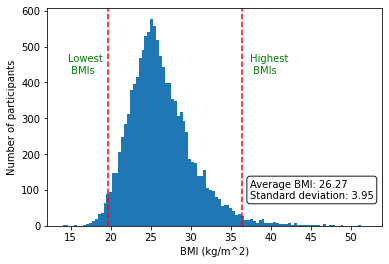

In [29]:
from matplotlib import pyplot as plt
plt.hist(BMI_redcap['BMI'],bins=2*int(np.ceil(np.max(high_BMI_values))),range=(int(np.floor(np.min(low_BMI_values))),int(np.ceil(np.max(high_BMI_values)))))

#Name x axis as 'BMI (kg/m^2)' and y axis as 'Number of participants'
plt.xlabel('BMI (kg/m^2)')
plt.ylabel('Number of participants')

#Add average BMI and std of it as legend
avg_bmi=np.round(np.mean(BMI_redcap['BMI']),2)
std_bmi=np.round(np.std(BMI_redcap['BMI']),2)
legend_text = f'Average BMI: {avg_bmi} \nStandard deviation: {std_bmi}'
plt.text(np.min(high_BMI_values) +1, 100, legend_text, rotation=0, verticalalignment='center',color='black',bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.3'))

#Draw two vertical lines in highest of the lowest BMI values and on the lowest of the highest BMI values

plt.axvline(x=np.max(low_BMI_values), color='r', linestyle='--')
plt.axvline(x=np.min(high_BMI_values), color='r', linestyle='--')

# Add text to the right side of the vertical line
text_to_display = 'Highest \n BMIs'
plt.text(np.min(high_BMI_values) + 1, 450, text_to_display, rotation=0, verticalalignment='center',color='green')

# Add text to the left side of the vertical line
text_to_display = 'Lowest \n BMIs'
plt.text(np.max(low_BMI_values) - 5, 450, text_to_display, rotation=0, verticalalignment='center',color='green')

#Save figure with axis text displayed in white color
plt.savefig('BMI_distribution.png',bbox_inches='tight',facecolor='white', edgecolor='white')

# print("Average BMI is",np.round(np.mean(BMI_redcap['BMI']),2),'and the standard deviation is',np.round(np.std(BMI_redcap['BMI']),2))

In [30]:
#Count number of values in normal BMI range in both low and high BMI groups

count_low = len([value for value in low_BMI_values if value > 18.5])
print("Number of participants with low BMI falling in normal range (>18.5) is:",count_low)

count_high= len([value for value in high_BMI_values if value < 25])
print("Number of participants with high BMI falling in normal range (<25) is:",count_high)

Number of participants with low BMI falling in normal range (>18.5) is: 124
Number of participants with high BMI falling in normal range (<25) is: 0


Check overlap with emphysema experiment

In [31]:
BMI_redcap_emph=BMI_redcap[((BMI_redcap['BMI']>=np.min(high_BMI_values)) | (BMI_redcap['BMI']<=np.max(low_BMI_values))) & 
                           (BMI_redcap['participant_id'].isin((list(high_BMI['patientID'].values))+(list(low_BMI['patientID'].values))))]

In [32]:
#Patient IDs of individuals with advanced, moderate, and noemphysema
adv_pats=[....] 

mod_pats=[....]

conf_pats=[....]  

noemph_pats=[....]

In [6]:
print("Emphysema cases that exist in BMI experiment:")
for pat in adv_pats+mod_pats+conf_pats:
    if pat in BMI_redcap_emph['participant_id'].values:
        print(pat)
print('\n')
print("Non-Emphysema cases that exist in BMI experiment:")
for pat in noemph_pats:
    if pat in BMI_redcap_emph['participant_id'].values:
        print(pat)

In [34]:
print("Overall, there are a lot of emphysema cases but with mild or trace emphysema \n")
BMI_redcap_emph['emph_yesno'].value_counts()

Overall, there are a lot of emphysema cases but with mild or trace emphysema 



1.0    180
0.0    172
Name: emph_yesno, dtype: int64

Not Used - Select participants based on different BMI thresholds to calculate sensitivity (in other script)

In [35]:
BMI_redcap_thresh_high=BMI_redcap[((BMI_redcap['BMI']>=np.min(high_BMI_values)) & (BMI_redcap['BMI']<=np.max(high_BMI_values))) &
                                  (BMI_redcap['participant_id'].isin((list(high_BMI['patientID'].values))))] 
# BMI_redcap_thresh_high

In [36]:
high_thresholds={}

for thresh in np.sort(np.unique(high_BMI_values)): #Sort and avoid duplicates

    higher_than_thresh=BMI_redcap_thresh_high[BMI_redcap_thresh_high['BMI']<=thresh] #Keep only those rows with BMI lower than threshold
    high_thresholds[thresh]=higher_than_thresh['participant_id'].values #Add to dictionary
    # print('Number of participants with BMI higher than',thresh,'is:',len(higher_than_thresh))

# print("High BMI thresholds and participants with BMI higher than that: \n", high_thresholds)

In [37]:
BMI_redcap_thresh_low=BMI_redcap[((BMI_redcap['BMI']>=np.min(low_BMI_values)) & (BMI_redcap['BMI']<=np.max(low_BMI_values))) &
                                  (BMI_redcap['participant_id'].isin((list(low_BMI['patientID'].values))))] 
# BMI_redcap_thresh_low

In [38]:
low_thresholds={}

for thresh in np.sort(np.unique(low_BMI_values)): #Sort and avoid duplicates

    lower_than_thresh=BMI_redcap_thresh_low[BMI_redcap_thresh_low['BMI']<=thresh] #Keep only those rows with BMI lower than threshold
    low_thresholds[thresh]=lower_than_thresh['participant_id'].values #Add to dictionary
    # print('Number of participants with BMI lower than',thresh,'is:',len(lower_than_thresh))

# print("Low BMI thresholds and participants with BMI lower than that: \n", low_thresholds)